# Stock Closing Price Prediction Using LSTM RNN

In [2]:
import csv
import pandas as pd 
import numpy as np
import requests
from io import StringIO
import pandas_datareader as pdd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, LSTM, Dropout
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
import matplotlib.pyplot as plt
import time
from datetime import datetime, timedelta


## Scraping Historical Stock Data from Yahoo Finance 

In [3]:
#Scrape 5 year 'GOOG' historical data f using an API call
stock="GOOG"
stock_url=f'https://query1.finance.yahoo.com/v7/finance/download/{stock}?'
params={"range":"5y",
        "interval":"1d",
        "events":"history"}
response = requests.get(stock_url,params=params)

#Format data into list
file= StringIO(response.text)
reader= csv.reader(file)
data= list(reader)

In [4]:
#Format list into Pandas DataFrame
df=pd.DataFrame(data, columns=data[0])
df.set_index(["Date"],drop=True, inplace=True)
df.drop("Date",inplace=True)
df.index=pd.to_datetime(df.index)
#Convert values from strings to floats
df=df.apply(pd.to_numeric)

## Feature Creation of Stock Indicators 

In [5]:
#Create the Simple Moving Average (SMA)
def SMA(data, length=30, column="Close"):
    return data[column].rolling(window=length).mean()

#Create the Exponential Moving Average (EMA)
def EMA(data, length=20, column='Close'):
    return data[column].ewm(span=length, adjust = False).mean()

df["SMA"]=SMA(df)
df["EMA"]=EMA(df)

In [6]:
# Add Relative Strength Index (RSI) to dataframe
def RSI(data, length=14):
    difference = data["Close"].diff(1)
    difference = difference[1:]
    positive = difference.copy()
    negative = difference.copy()
    positive[positive < 0] = 0
    negative[negative > 0] = 0
    data["positive"] = positive 
    data["negative"] = negative 
    average_gain = SMA(data, length, column="positive")
    average_loss = abs(SMA(data, length, column ="negative"))
    rs = average_gain/ average_loss
    RSI = 100.0 - (100.0/(1.0 + rs))
    data["RSI"] = RSI
    data.drop(["positive", "negative"], axis=1, inplace=True)
    return data
    
    
RSI(df)

,Open,High,Low,Close,Adj Close,Volume,SMA,EMA,RSI
Date,,,,,,,,,
2016-02-22,707.450012,713.239990,702.510010,706.460022,706.460022,1949800,NaN,706.460022,NaN
2016-02-23,701.450012,708.400024,693.580017,695.849976,695.849976,2009300,NaN,705.449541,NaN
2016-02-24,688.919983,700.000000,680.780029,699.559998,699.559998,1963600,NaN,704.888633,NaN
2016-02-25,700.010010,705.979980,690.585022,705.750000,705.750000,1642200,NaN,704.970668,NaN
2016-02-26,708.580017,713.429993,700.859985,705.070007,705.070007,2243500,NaN,704.980128,NaN
...,...,...,...,...,...,...,...,...,...
2021-02-16,2104.360107,2152.679932,2104.360107,2121.899902,2121.899902,1132900,1900.409668,1990.944675,71.467237
2021-02-17,2100.000000,2133.659912,2098.919922,2128.310059,2128.310059,1070100,1913.745337,2004.027093,87.505055
2021-02-18,2110.389893,2132.735107,2103.709961,2117.199951,2117.199951,1121600,1926.288000,2014.805460,83.839854


In [7]:
#Calculate Moving Average Convergence/Divergence (MACD)
def MACD(data, length_long=26, length_short=12, length_signal=9, column="Close"):
    short = EMA(data,length_short, column=column)
    long = EMA(data, length_long, column=column)
    data["MACD"] = short - long
    data["Signal"] = EMA(data, length_signal, column="MACD")
    
    return data
MACD(df)

,Open,High,Low,Close,Adj Close,Volume,SMA,EMA,RSI,MACD,Signal
Date,,,,,,,,,,,
2016-02-22,707.450012,713.239990,702.510010,706.460022,706.460022,1949800,NaN,706.460022,NaN,0.000000,0.000000
2016-02-23,701.450012,708.400024,693.580017,695.849976,695.849976,2009300,NaN,705.449541,NaN,-0.846385,-0.169277
2016-02-24,688.919983,700.000000,680.780029,699.559998,699.559998,1963600,NaN,704.888633,NaN,-1.203906,-0.376203
2016-02-25,700.010010,705.979980,690.585022,705.750000,705.750000,1642200,NaN,704.970668,NaN,-0.976506,-0.496264
2016-02-26,708.580017,713.429993,700.859985,705.070007,705.070007,2243500,NaN,704.980128,NaN,-0.841460,-0.565303
...,...,...,...,...,...,...,...,...,...,...,...
2021-02-16,2104.360107,2152.679932,2104.360107,2121.899902,2121.899902,1132900,1900.409668,1990.944675,71.467237,85.438989,73.208216
2021-02-17,2100.000000,2133.659912,2098.919922,2128.310059,2128.310059,1070100,1913.745337,2004.027093,87.505055,85.736026,75.713778
2021-02-18,2110.389893,2132.735107,2103.709961,2117.199951,2117.199951,1121600,1926.288000,2014.805460,83.839854,84.105422,77.392107


In [8]:
#Drop all rows with NaN values
df.dropna(inplace=True)

## Principal Component Analysis 

In [11]:
#Using PCA to attempt feature selection
total_x=np.array(df.loc[:,["Open","High","Low","Close","Volume","SMA","EMA","RSI","MACD","Signal"]])
x_normalized = StandardScaler().fit_transform(total_x)
pca= PCA(n_components=10).fit(x_normalized)

n_pcs= pca.components_.shape[0]

# Get the index of the most important feature on each component
most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]

#Feature names in order 
initial_feature_names = ["Open","High","Low","Close","Volume","SMA","EMA","RSI","MACD","Signal"]
# Get the names 
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]


dic = {'PC{}'.format(i): most_important_names[i] for i in range(n_pcs)}

# Return a DataFrame sorted by PC
df2 = pd.DataFrame(dic.items())


df

,Open,High,Low,Close,Adj Close,Volume,SMA,EMA,RSI,MACD,Signal
Date,,,,,,,,,,,
2016-04-04,750.059998,752.799988,742.429993,745.289978,745.289978,1134200,723.363668,734.280929,62.982432,9.549177,8.743968
2016-04-05,738.000000,742.799988,735.369995,737.799988,737.799988,1132300,724.408333,734.616078,57.596630,8.645569,8.724288
2016-04-06,735.770020,746.239990,735.559998,745.690002,745.690002,1053700,726.069668,735.670737,57.684888,8.468491,8.673129
2016-04-07,745.369995,747.000000,736.280029,740.280029,740.280029,1453200,727.427002,736.109717,51.888787,7.801683,8.498840
2016-04-08,743.969971,745.450012,735.549988,739.150024,739.150024,1290800,728.540336,736.399270,51.154512,7.100204,8.219112
...,...,...,...,...,...,...,...,...,...,...,...
2021-02-16,2104.360107,2152.679932,2104.360107,2121.899902,2121.899902,1132900,1900.409668,1990.944675,71.467237,85.438989,73.208216
2021-02-17,2100.000000,2133.659912,2098.919922,2128.310059,2128.310059,1070100,1913.745337,2004.027093,87.505055,85.736026,75.713778
2021-02-18,2110.389893,2132.735107,2103.709961,2117.199951,2117.199951,1121600,1926.288000,2014.805460,83.839854,84.105422,77.392107


In [12]:
#List of Principal Components sorted from most important to least.
df2

,0,1
0,PC0,Low
1,PC1,MACD
2,PC2,Volume
3,PC3,RSI
4,PC4,MACD
5,PC5,EMA
6,PC6,Open
7,PC7,Low
8,PC8,EMA
9,PC9,High


In [13]:
#Adds last 5 principle components to a list if they were not included in the first 5. 
drop_list=[h for h in df.columns if h in df2[1][-5:].values and h not in df2[1][:-5].values]

In [14]:
if "Adj Close" not in drop_list:
    drop_list.append("Adj Close")

## LSTM Model Creation, Training, Optimization and Plotting

In [15]:
#Any data after 1-1-2021 will be used as testing data and data before will be used as training data. 
training_data = df[df.index <'2021-01-01']
test_data = df[df.index >= '2021-01-01']

Train on 897 samples, validate on 34 samples
Epoch 1/20
897/897 [==============================] - ETA: 2:54 - loss: 0.262 - ETA: 1:43 - loss: 0.239 - ETA: 1:15 - loss: 0.233 - ETA: 59s - loss: 0.207 - ETA: 48s - loss: 0.18 - ETA: 41s - loss: 0.15 - ETA: 34s - loss: 0.15 - ETA: 28s - loss: 0.13 - ETA: 22s - loss: 0.12 - ETA: 17s - loss: 0.11 - ETA: 13s - loss: 0.11 - ETA: 8s - loss: 0.1053 - ETA: 4s - loss: 0.101 - ETA: 0s - loss: 0.099 - 63s 70ms/sample - loss: 0.0994 - val_loss: 0.4889
Epoch 2/20
897/897 [==============================] - ETA: 43s - loss: 0.05 - ETA: 41s - loss: 0.04 - ETA: 38s - loss: 0.03 - ETA: 34s - loss: 0.03 - ETA: 31s - loss: 0.03 - ETA: 27s - loss: 0.02 - ETA: 24s - loss: 0.02 - ETA: 21s - loss: 0.02 - ETA: 17s - loss: 0.02 - ETA: 14s - loss: 0.02 - ETA: 10s - loss: 0.02 - ETA: 7s - loss: 0.0240 - ETA: 3s - loss: 0.023 - ETA: 0s - loss: 0.023 - 52s 58ms/sample - loss: 0.0230 - val_loss: 0.1614
Epoch 3/20
897/897 [==============================] - ETA: 44s - l

897/897 [==============================] - ETA: 46s - loss: 0.00 - ETA: 43s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 35s - loss: 0.00 - ETA: 32s - loss: 0.00 - ETA: 29s - loss: 0.00 - ETA: 25s - loss: 0.00 - ETA: 21s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 7s - loss: 0.0042 - ETA: 3s - loss: 0.004 - ETA: 0s - loss: 0.004 - 54s 60ms/sample - loss: 0.0041 - val_loss: 0.0088
Epoch 18/20
897/897 [==============================] - ETA: 45s - loss: 0.00 - ETA: 41s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 34s - loss: 0.00 - ETA: 31s - loss: 0.00 - ETA: 28s - loss: 0.00 - ETA: 25s - loss: 0.00 - ETA: 22s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 7s - loss: 0.0043 - ETA: 3s - loss: 0.004 - ETA: 0s - loss: 0.004 - 54s 61ms/sample - loss: 0.0044 - val_loss: 0.0118
Epoch 19/20
897/897 [==============================] - ETA: 56s - loss: 0.00 - ETA: 47s - loss: 0.00 - ETA: 42s - loss: 0.00 - E

INFO:tensorflow:Oracle triggered exit


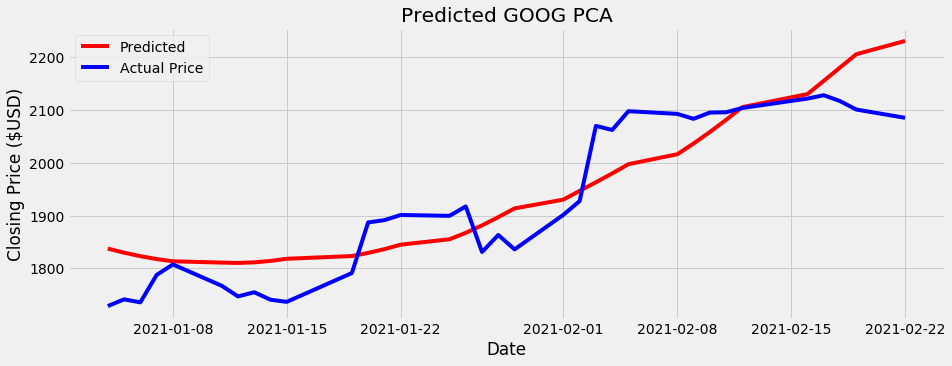

Train on 897 samples, validate on 34 samples
Epoch 1/20
897/897 [==============================] - ETA: 3:01 - loss: 0.240 - ETA: 1:44 - loss: 0.235 - ETA: 1:17 - loss: 0.212 - ETA: 1:01 - loss: 0.188 - ETA: 50s - loss: 0.160 - ETA: 42s - loss: 0.13 - ETA: 36s - loss: 0.13 - ETA: 30s - loss: 0.12 - ETA: 24s - loss: 0.10 - ETA: 19s - loss: 0.10 - ETA: 14s - loss: 0.09 - ETA: 9s - loss: 0.0920 - ETA: 4s - loss: 0.089 - ETA: 0s - loss: 0.086 - 72s 80ms/sample - loss: 0.0864 - val_loss: 0.4350
Epoch 2/20
897/897 [==============================] - ETA: 47s - loss: 0.03 - ETA: 42s - loss: 0.03 - ETA: 39s - loss: 0.03 - ETA: 35s - loss: 0.03 - ETA: 31s - loss: 0.02 - ETA: 28s - loss: 0.02 - ETA: 25s - loss: 0.02 - ETA: 21s - loss: 0.02 - ETA: 18s - loss: 0.02 - ETA: 14s - loss: 0.02 - ETA: 10s - loss: 0.02 - ETA: 7s - loss: 0.0240 - ETA: 3s - loss: 0.023 - ETA: 0s - loss: 0.022 - 54s 60ms/sample - loss: 0.0227 - val_loss: 0.2307
Epoch 3/20
897/897 [==============================] - ETA: 1:00 

897/897 [==============================] - ETA: 50s - loss: 0.00 - ETA: 46s - loss: 0.00 - ETA: 41s - loss: 0.00 - ETA: 38s - loss: 0.00 - ETA: 35s - loss: 0.00 - ETA: 31s - loss: 0.00 - ETA: 27s - loss: 0.00 - ETA: 24s - loss: 0.00 - ETA: 20s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 12s - loss: 0.00 - ETA: 8s - loss: 0.0065 - ETA: 4s - loss: 0.006 - ETA: 0s - loss: 0.006 - 61s 67ms/sample - loss: 0.0065 - val_loss: 0.0132
Epoch 18/20
897/897 [==============================] - ETA: 49s - loss: 0.00 - ETA: 44s - loss: 0.00 - ETA: 40s - loss: 0.00 - ETA: 36s - loss: 0.00 - ETA: 32s - loss: 0.00 - ETA: 28s - loss: 0.00 - ETA: 25s - loss: 0.00 - ETA: 21s - loss: 0.00 - ETA: 18s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 10s - loss: 0.00 - ETA: 7s - loss: 0.0047 - ETA: 3s - loss: 0.004 - ETA: 0s - loss: 0.004 - 53s 59ms/sample - loss: 0.0045 - val_loss: 0.0110
Epoch 19/20
897/897 [==============================] - ETA: 49s - loss: 0.00 - ETA: 45s - loss: 0.00 - ETA: 41s - loss: 0.00 - E

INFO:tensorflow:Oracle triggered exit


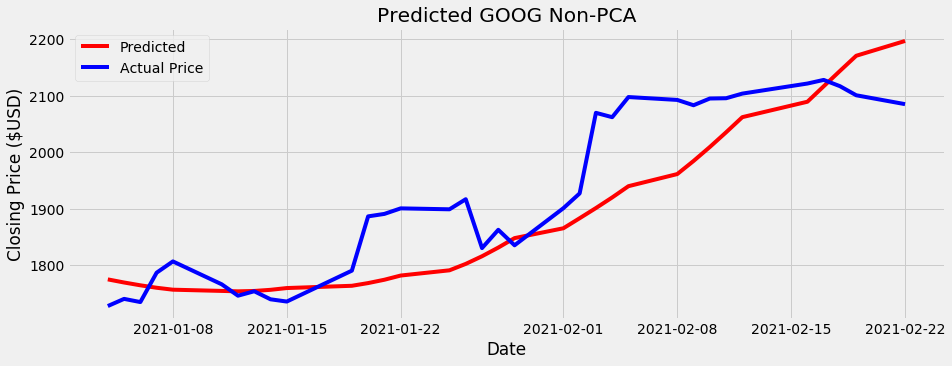

In [22]:
#For loop to train model and test model on data with feature selection using PCA and one without. 
for count,i in enumerate([drop_list,["Adj Close"]]):
    #Dropping columns that have less importance as per PCA or dropping just Adj Close.
    training_data1= training_data.drop(columns=i)
    #Create one scaler for x values and one for y values.
    scalerx=MinMaxScaler()
    scalery=MinMaxScaler()
    #Fit the data to the scalers. 
    training_x= scalerx.fit_transform(training_data1)
    training_y= scalery.fit_transform(np.array(training_data["Close"]).reshape(-1,1))

    #Append n days of data to a list, and append the price of the n+1 day to a list iteratively. 
    X_train=[]
    y_train = []
    for n in range(300, len(training_x)):
        X_train.append(training_x[n-300:n])
        y_train.append(training_y[n])
    
    #Convert X_train and y_train into numpy arrays
    X_train, y_train = np.array(X_train), np.array(y_train)

    #Format the test data to predict the prices of 32 days, based on their respective pools of 200 days of data.
    past_data=training_data.tail(300)
    test_set = pd.concat([past_data,test_data])
    test_set.drop(columns=i,inplace=True)

    #Scale the test data
    scaled_x_test= scalerx.transform(test_set)
    scaled_y_test= scalery.transform(np.array(test_set["Close"]).reshape(-1,1))

    X_test=[]
    y_test=[]

    #Append n days of data to a list, and append the price of the n+1 day to a list iteratively.
    for d in range(300,len(scaled_x_test)):
        X_test.append(scaled_x_test[d-300:d])
        y_test.append(scaled_y_test[d])
    
    X_test, y_test = np.array(X_test), np.array(y_test)
    
    #Set different values for units and dropout to be optimized by Keras tuner
    def build_regressor(hp):
        regressor= Sequential()
    
        regressor.add(LSTM(hp.Int("input_units", 80, 120, 20), activation = "relu", return_sequences=True, input_shape=(X_train.shape[1],X_train.shape[2])))
        regressor.add(Dropout(hp.Float('dropout',0,0.5,.1)))

        regressor.add(LSTM(hp.Int("input_units", 80, 140, 20), activation = "relu", return_sequences=True))
        regressor.add(Dropout(hp.Float('dropout',0,0.5,.1)))

        regressor.add(LSTM(hp.Int("input_units", 80, 160, 20), activation = "relu", return_sequences=True))
        regressor.add(Dropout(hp.Float('dropout',0,0.5,.1)))
    
        regressor.add(LSTM(hp.Int("input_units", 80, 180, 20), activation = "relu"))
        regressor.add(Dropout(hp.Float('dropout',0,0.5,.1)))

 
        regressor.add(Dense(units=1))
    
        regressor.compile(optimizer='adam', loss='mean_squared_error')
    
        return regressor
    
    #Create tuner to optimize for loss on validation data. 
    tuner = RandomSearch(
        build_regressor,
        objective="val_loss",
        max_trials=1,
        executions_per_trial = 1,
        directory=time.time()
        )
    tuner.search(x=X_train,y=y_train, epochs=20, batch_size=64,validation_data=(X_test, y_test))
    
    # Predict price using the best model
    predict=tuner.get_best_models()[0].predict(X_test)
    
    #Extract dates to use for X values in plot.
    dates=test_set.index[-len(test_data):]
    
    #Plot predicted price aganist actual price
    plt.style.use('fivethirtyeight')
    plt.figure(figsize=(14,5))
    plt.plot(dates,scalery.inverse_transform(predict), color="red", label="Predicted")
    plt.plot(dates,scalery.inverse_transform(y_test), color="blue", label="Actual Price")
    plt.legend()
    plt.xlabel("Date")
    plt.ylabel("Closing Price ($USD)")
    if count==0:
          plt.title(f"Predicted {stock} PCA")
    else:
          plt.title(f"Predicted {stock} Non-PCA")
    plt.show()
    

## Single Day Price Predictor Using Best Model

In [24]:
#Function to predict price. Takes date to be predicted as an input and uses Non-PCA model to make prediction.

df.reset_index(inplace=True)
def predictor(date):
    enddate=(df[df["Date"]==pd.to_datetime(date)].index[0])
    startdate=enddate-300
    newdf=df.loc[startdate:enddate-1,:]
    newdf.drop(columns=["Adj Close"],inplace=True)
    newdf.drop(columns="Date",inplace=True)
    scaledpredict=scalerx.transform(np.array(newdf))
    scaledpredict=scaledpredict.reshape(1,300,newdf.shape[1])
    predicted=tuner.get_best_models()[0].predict(scaledpredict)
    return scalery.inverse_transform(predicted)[0][0]
predictor("2021-02-22")

/Users/brandonbracho/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


2197.2375